In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context("poster")
sns.set(style="whitegrid", color_codes = False)
from pandas.tools.plotting import scatter_matrix
pd.set_option('display.max_columns', 50)
from scipy.stats import chi2_contingency

#read in data as csv
readmit = pd.read_csv('diabetic_data.csv')

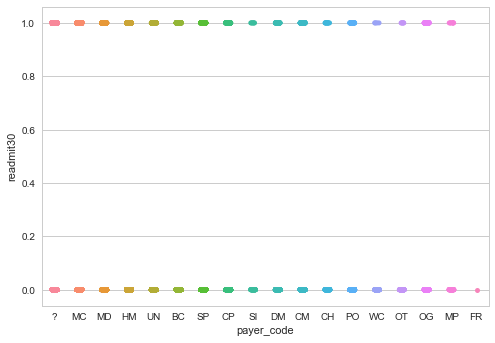

In [2]:
#cleaning data 

 #for logistic regn. and simplicity, turn readmission variable into binary (readmitted w/in 30 days or not)
readmit['readmit30'] = np.where(readmit['readmitted'] == '<30', 1, 0)

 #check for relationship b/w payer code (52% missing) and readmission
sns.stripplot(x = 'payer_code', y = 'readmit30', data = readmit, jitter = True) 

In [3]:
 #check for relationship b/w physician specialty (53% missing) and readmission
#sns.stripplot(x = 'medical_specialty', y = 'readmit30', data = readmit, jitter = True) 

In [4]:
 #drop readmitted, weight (92% missing), payer code, and specialty of admitting physician 
readmit_drop = readmit.drop(['readmitted', 'weight', 'medical_specialty', 'payer_code'], axis = 1)


In [5]:
 #reduce df so that there's one (the first) encounter/patient -- use lowest encounter_id by convention
readmit_sortP = readmit_drop.sort_values(['patient_nbr', 'encounter_id'])
readmit_no_dups = readmit_sortP.drop_duplicates(['patient_nbr'])

 #remove encounters that resulted in either discharge to a hospice or patient death (need indep. observations)
readmit_discharge_clean = readmit_no_dups[((readmit_no_dups.discharge_disposition_id != 11) & 
                                          (readmit_no_dups.discharge_disposition_id != 13) &
                                          (readmit_no_dups.discharge_disposition_id != 14) & 
                                          (readmit_no_dups.discharge_disposition_id != 19) & 
                                          (readmit_no_dups.discharge_disposition_id != 20) & 
                                          (readmit_no_dups.discharge_disposition_id != 21))] 
 #check results
discharge = readmit_discharge_clean.groupby('discharge_disposition_id').size()

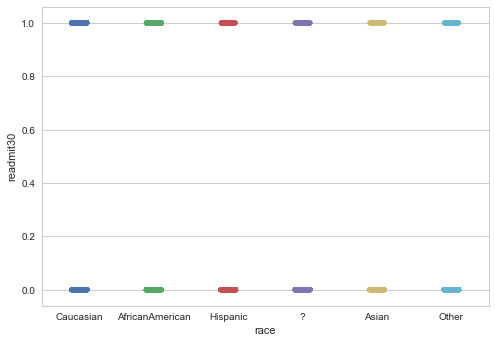

In [6]:
 #address missingness in race (3%), diagnosis 3 (<2%), and diagnosis 1 and 2 (both well below 1%)
#readmit_no_dups.groupby(['race']).size()
sns.stripplot(x = 'race', y = 'readmit30', data = readmit_discharge_clean, jitter = True) 

 #remove obs w/ missing race and diagnosis 3
readmit_full_race = readmit_discharge_clean[((readmit_discharge_clean.race != '?') & 
                                             (readmit_discharge_clean.diag_1 != '?') &
                                             (readmit_discharge_clean.diag_2 != '?') &
                                             (readmit_discharge_clean.diag_3 != '?'))]

In [7]:
 #change all remaining ?s to NaN
to_NaN = readmit_full_race.replace('?', np.NaN)
    
 #check for NaN in rows
pd.options.display.max_rows = 75
checkNA = to_NaN.isnull().sum()

 #check balance of data (6074 1's, 60770 0's) -- unbalanced 
y = to_NaN.groupby('readmit30').size()

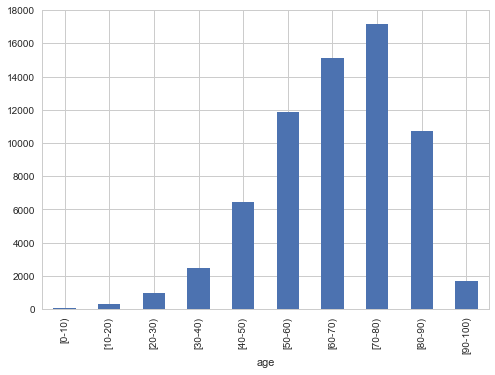

In [8]:
#check for dependence/multicollinearity
    #age has a left-skewed distribution -- check agst. number vars
age_grouped = to_NaN.groupby(['age']).size()
age_grouped.plot(kind = 'bar')

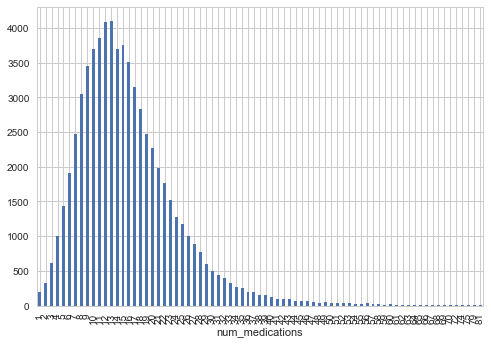

In [9]:
 #number of medications is right-skewed
num_meds = to_NaN.groupby(['num_medications']).size()
num_meds.plot(kind = 'bar') 

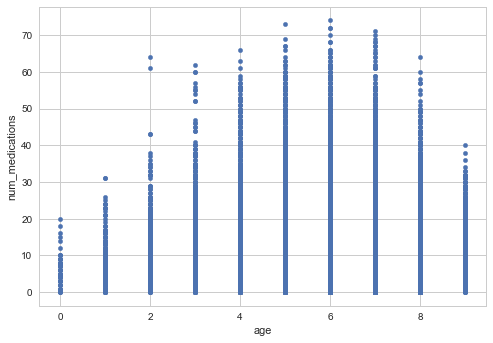

In [11]:
 #check viability of chi square test for independence -- some expected values too small
#pd.crosstab(index = to_NaN['num_medications'], columns = to_NaN['age'])

 #set desired cols to categorical for scatter analysis
to_cats = to_NaN.loc[:,('age', 'num_medications')]

for col in to_cats:
    to_cats[col] = to_cats[col].astype('category')

df_num = to_cats.apply(lambda x: x.cat.codes)
 
 #check age vs. number of medications -- no apparent association
df_num.plot.scatter('age', 'num_medications')

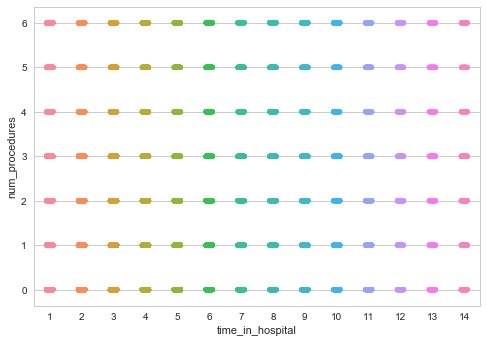

In [12]:
#check time in hospital vs. number of procedures -- no evidence of dependence 
sns.stripplot(x = 'time_in_hospital', y = 'num_procedures', data = to_NaN, jitter = True) 

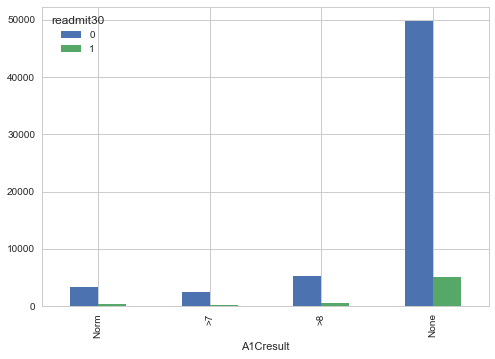

In [65]:
#look at relationships with output variable -- look for something closely associated w/ readmission 

 #create cross-tab for initial evaluation and make df for later bar plot
outcome_ct = pd.crosstab(index = to_NaN['A1Cresult'], columns = to_NaN['readmit30'])
ct_df = pd.DataFrame(outcome_ct.reset_index())

 #make bar chart w/ ordered HbA1c levels -- no apparent relationship with readmission
levels = ['Norm', '>7', '>8', 'None']
mapping = {level: i for i, level in enumerate(levels)} #assign nos. to levels based on desired ordinality
key = ct_df['A1Cresult'].map(mapping) #map level ordinals to df rows    
sorting = ct_df.iloc[key.argsort()] #create df w/ desired order from matched ordinals
sorting.plot(kind = 'bar', x = 'A1Cresult')

In [ ]:
#split patients into those readmitted and those not, then see who had HbA1c test ('A1Cresult') done and who didn't 
    #and total #tests and patients on each side -- proportions 
    #authors' paper: measurement of HbA1c performed 18.4% of time

In [ ]:
#scatter_matrix(to_NaN[['var1', 'var2', 'var3']])